## Viewing and Inspecting Data


In [11]:
import sys
sys.path.append('../')

In [12]:
from pylab import rcParams
rcParams['figure.figsize'] = (14, 10)

In [13]:
from importlib import reload
import libs.importing as importing
import libs.render as renderx
reload(importing)
reload(render)

source_dir = 'd59fe403'

ds = importing.DataSource(source_dir)
ds.load_data()

In [15]:
reload(render)
reload(importing)
import libs.debug as debug
import shutil
import os
import cv2

if os.path.isdir('./decisions'):
    shutil.rmtree('./decisions')
os.makedirs('./decisions')
os.makedirs('./decisions/01_good')
os.makedirs('./decisions/02_maybe')
os.makedirs('./decisions/03_bad')

for idx in range(len(ds.image_data)):
    img = render.draw_image_data_at_index(ds, idx)
    cv2.imwrite(os.path.join('./decisions', ds.image_names[idx]), cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

2018-04-17 08:00:19,038 [DEBUG]: Found GEOS DLL: <CDLL '/home/che/anaconda3/lib/python3.6/site-packages/shapely/.libs/libgeos_c-bd8d3f16.so.1.10.2', handle 564d7eb45820 at 0x7f6970555ef0>, using it.
2018-04-17 08:00:19,057 [DEBUG]: Trying `CDLL(libc.so.6)`
2018-04-17 08:00:19,059 [DEBUG]: Library path: 'libc.so.6'
2018-04-17 08:00:19,059 [DEBUG]: DLL: <CDLL 'libc.so.6', handle 7f69d0c064f0 at 0x7f6970555cc0>


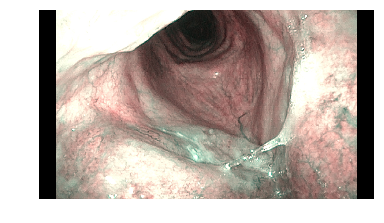

In [6]:
reload(importing)
import libs.bounding_box as bounding_box
import libs.patch_tools as patch_tools
img_index = ds.get_index_for_image_id('hgv-8cdc40c2')

img_id, img_name, img, roi_ids, rois, roi_labels = ds.get_data_at(img_index)

fimg = render.flip_channels(img.copy())

for roi in rois:
    bb = bounding_box.generate_bounding_box(fimg, roi)
    patches, points = patch_tools.generate_patches(fimg, bb, patch_size=64, patch_overlap=0.5)
    filtered_patches, filtered_points = patch_tools.filter_patches(patches, roi, points)
    render.draw_roi_on_image(fimg, roi)
    render.draw_bounding_box_on_image(fimg, bb)
    fimg = render.draw_patches_on_image(fimg, filtered_points, patch_size = 64)
render.plot_image(fimg)
render.flip_and_plot_image(img)

In [8]:
from keras.models import load_model
import numpy as np
import libs.stats as stats
reload(stats)
reload(render)

def predict(model, img, roi):
    bb = bounding_box.generate_bounding_box(img, roi)
    patches, points = patch_tools.generate_patches(img, bb, patch_size=64, patch_overlap=0.5)
    filtered_patches, filtered_points = patch_tools.filter_patches(patches, roi, points)
    
    # preprocess patches : simple normalization
    k = np.array(filtered_patches, dtype=np.float32)
    k /= 255
    
    # make predictions
    y_pred_oh = model.predict(k)
    #pred_labels = np.random.choice([0,1,2,3], len(k), replace=True)
    print(y_pred_oh[0])
    
    # convert from one-hot encoding back to 'normal' encoding
    pred_labels = np.argmax(y_pred_oh, axis=1)
    #img = render.draw_patches_heatmap_on_image(img, filtered_points, pred_labels)
    #render.plot_image(img)
    
    coverage = stats.get_label_coverage_for_roi(pred_labels)
    print('coverage: {}'.format(coverage))
    print('should take tissue sample? {}'.format(stats.should_take_tissue_sample(coverage, threshold_label=2, threshold_value=0.4)))
    
# we've selected this roi
print('SELECTED REGION =====')
roi = rois[0]
img2 = render.flip_channels(img.copy())
#render.plot_image_with_roi(img2.copy(), roi)

model = load_model('../research1.h5')

predict(model, img2, roi)

SELECTED REGION =====
[0.13159111 0.004479   0.86392987]
coverage: [0.12295082 0.         0.87704918 0.        ]
should take tissue sample? True
